In [17]:
# default_exp model.base

In [1]:
# hide
import sys

sys.path.append("..")
import pandas as pd

/home/tako/dev/env37/lib/python3.7/site-packages/pandas/compat/__init__.py:117: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [2]:
# hide
from nbdev.showdoc import *

# M5 Base Model

In [3]:
# export
from fastseq.core import *
from fastseq.data.load import *
from fastseq.data.core import *
from fastseq.data.procs import *
from fastcore.all import *
from fastcore.imports import *
from fastai2.basics import *
from fastai2.data.transforms import *
from fastai2.tabular.core import *
from fastai2.torch_basics import *
from fastai2.callback.all import *
from fastseq.metrics import *

In [4]:
from tqdm import tqdm

In [5]:
path = Path('../data/m5/rows')

In [6]:
list(path.glob('*.json'))[0]

Path('../data/m5/rows/FOODS_2_155_WI_2.json')

In [8]:
new_path = Path('../data/m5/rows2')
if not new_path.exists(): new_path.mkdir()
for f in tqdm(list(path.glob('*.json'))):
    f.copy(new_path / f.name)
        
(path / '.ts_meta').copy(new_path / '.ts_meta')

100%|██████████| 30490/30490 [00:09<00:00, 3223.03it/s]


In [9]:
path = new_path

moved to all
made evalutation
made validation
made val
{'Train': 4451540, 'Val': 1737930, 'Validation': 30490, 'Evaluation': 30490}


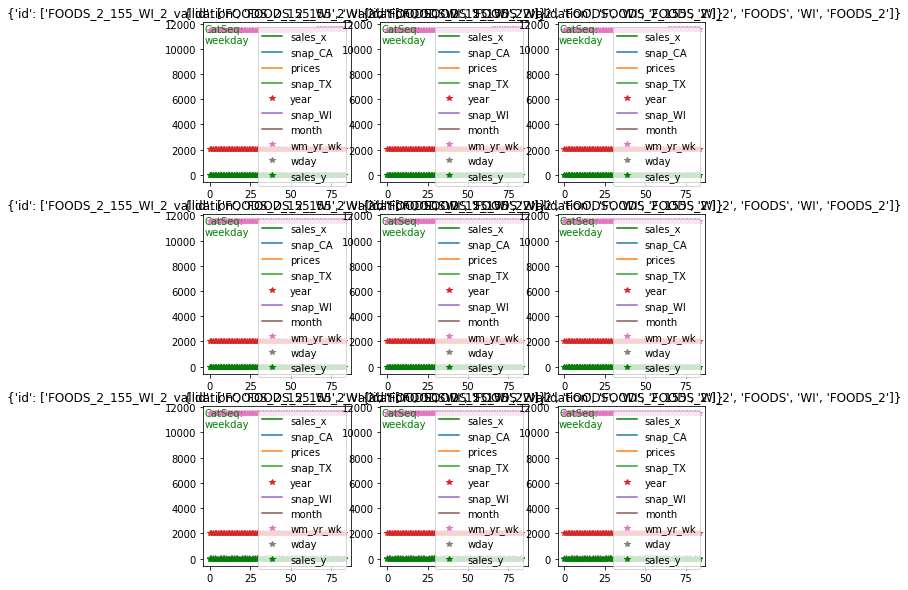

In [10]:
lookback, horizon = 28*2, 28
dl =  MTSDataLoaders.from_m5_path(path, 'sales', horizon = horizon, lookback = lookback,
                                  train_start = 1600, verbose = True,#after_batch = [NormalizeSeqMulti(n_its=5,skip=[0,5])]
                                 )
dl.show_batch()

In [192]:
%%time
for o in dl.train:
    pass

CPU times: user 2.36 s, sys: 611 ms, total: 2.97 s
Wall time: 6.04 s


In [11]:
for o in dl.train:
    o._dict()
    break

In [12]:
o[-1].mean(),o[-1].std(),o[0].mean(),o[0].std()

(TensorSeq(0.0809, device='cuda:0'),
 TensorSeq(1.0124, device='cuda:0'),
 TensorSeq(-3.0667e-08, device='cuda:0'),
 TensorSeq(0.9912, device='cuda:0'))

In [13]:
# export
class SeqTab(Module):
    """Basic model for sequential data."""
    def __init__(self, n_cont, out_sz, layers, y_range=None,):
        ps = [0]*len(layers)
        sizes = [n_cont] + layers + [out_sz]
        actns = [nn.ReLU(inplace=True) for _ in range(len(sizes)-2)] + [None]
        _layers = [LinBnDrop(sizes[i], sizes[i+1], bn=True and (i!=len(actns)-1), p=p, act=a)
                       for i,(p,a) in enumerate(zip(ps+[0.],actns))]
        if y_range is not None: _layers.append(SigmoidRange(*y_range))
        self.bn_cont = nn.BatchNorm1d(n_cont)
        if y_range is not None: _layers.append(SigmoidRange(*y_range))
        self.layers = nn.Sequential(*_layers)

    def forward(self, x, ts_con, ts_cat, cat, con):
        x_bn = self.bn_cont(x[:,0])
        o = [x, self.layers(x_bn)[:,None,:]]
        return torch.cat(o,-1)

In [14]:
lookback, horizon = 28*2, 28
mdl = SeqTab(lookback,horizon,[200])
shape = list(mdl(torch.randn(16,1,lookback),[],[],[],[]).shape)
test_eq(shape,(16,1,lookback+horizon))
print(shape)

[16, 1, 84]


In [15]:
#export
class M5Learner(Learner): pass

@delegates(M5Learner.__init__)
def SeqTabLearner(dls, layers=None,metrics=None, **kwargs):
    "Get a `Learner` using `data`, with `metrics`, including a `SeqTab` created using the remaining params."
    if layers is None: layers = [200,100]    
    model = SeqTab(dls.train.lookback, dls.train.horizon, layers,)
    return Learner(dls, model, loss_func = F.mse_loss, opt_func= ranger, metrics=L(metrics)+L(mae, smape,mae), **kwargs)

In [16]:
learn = SeqTabLearner(dl)

RuntimeError: cannot perform reduction function argmin on a tensor with no elements because the operation does not have an identity

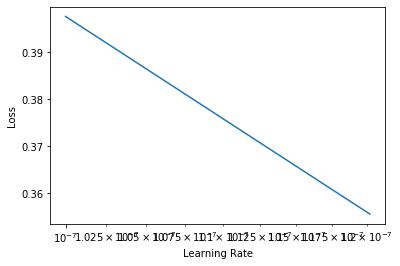

In [17]:
learn.lr_find()

In [18]:
learn.fit(1,1e-7)
learn.recorder.plot_loss()

TypeError: __init__() missing 2 required positional arguments: 'doc' and 'pos'

In [19]:
learn.show_results(show_kwargs = dict(extra = False))

KeyboardInterrupt: 

In [20]:
# export
# inputs,preds,targs,decoded,losses
def make_pred(learn, dl = 2):
    inputs,preds,targs,decoded,losses = learn.get_preds(3, with_decoded = True, with_input=True, with_loss=True)
    predictions = (decoded - targs[:,0,-28:].mean(-1)[:,None,None]).round() #TODO std
    return predictions[:,0,:]
    

0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


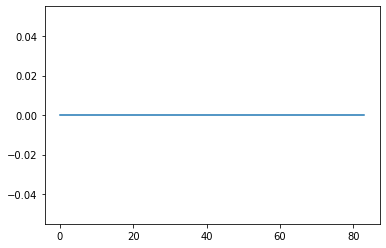

In [21]:

for pred in make_pred(learn, dl = 2):
    o =','.join(L(list(pred[-28:].numpy())).map(int).map(str))
    print(o)
    break
plt.plot(pred)        

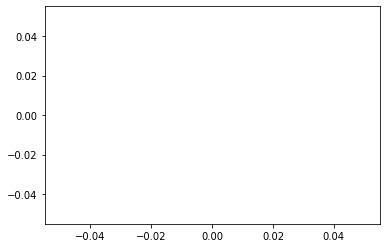

In [22]:
plt.plot(pred[-1,].T)

In [23]:
# export  
def make_submision_file(learn):
    dct = {}
    for i, (file, pred) in enumerate(zip(learn.dls[2].dataset, make_pred(learn, 2))):
        name = file.name.replace('.json','_validation')
        pred =','.join(L(list(pred[-28:].numpy())).map(int).map(str))
        dct[name] = pred

    for i, (file, pred) in enumerate(zip(learn.dls[3].dataset, make_pred(learn, 3))):
        name = file.name.replace('.json','_evaluation')
        pred =','.join(L(list(pred[-28:].numpy())).map(int).map(str))
        dct[name] = pred
    return dct

In [24]:
dct = make_submision_file(learn)
dct['HOBBIES_1_028_CA_1_validation']

'1,0,0,1,0,1,1,1,1,1,1,0,1,1,1,1,1,0,1,1,1,0,1,1,0,0,1,0'

In [33]:
# export
def make_file(learn, dct = None):
    if dct is None:
        dct = make_submision_file(learn)
    with open(learn.path / 'submision_file.csv','w') as f_w:
        with open(Path('../data/m5/sample_submission.csv'), 'r') as f:
            f_w.write('id,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28\n')
            _ = f.readline()
            for line in f:
                f_w.write(line.split(',')[0]+','+dct[line.split(',')[0]] + '\n')
    return dct
            
M5Learner.make_submision_file = make_submision_file

In [34]:
make_file(learn, dct)

In [35]:
!kaggle competitions submit -c m5-forecasting-accuracy -f '../data/m5/rows2/submision_file.csv' -m 'initial sub 0.0.1'

100%|███████████████████████████████████████| 4.99M/4.99M [00:06<00:00, 790kB/s]
Successfully submitted to M5 Forecasting - Accuracy

In [ ]:
# hide
from nbdev.export import *
notebook2script()

Converted 00_core.ipynb.
Converted 00_m5.ipynb.
Converted 01_data.external.ipynb.
Converted 02_data.load.ipynb.
Converted 03_data.core.ipynb.
Converted 04_data.procs.ipynb.


In [169]:
git_add('10_model.base.ipynb', commit_msg='initial model')

Converted 10_model.base.ipynb.


['/home/tako/dev/fastseq/fastseq/model/base.py',
 '/home/tako/dev/fastseq/nbs/10_model.base.ipynb']